In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from PIL import Image
from dataset import *
from save_load import *
from NN_library.AutoUnet.AutoUnet import *
from NN_library.AutoUnet.train_AutoUnet import *
%load_ext autoreload
%autoreload 2

Using device: cuda


Test U-Net

In [2]:
data = dataset_nonuniform()
loaders = get_loaders(data, 1)

In [8]:
#name = 'NN_library/AutoUnet/AutoUnet'
name = 'NN_library/AutoUnet/AutoUnet_pretrained'
args = {'lr' : 0.001, 'epochs' : 20, 'dev' : dev, 'name' : name}
unet = AutoUNet()
unet = load_network(unet, args['name'], args)

In [9]:
L_dam = test(unet, loaders, args)
L_dam = np.array(L_dam)

In [10]:
dam_mean = L_dam.mean()
dam_std = L_dam.std()
print('Mean damage, %:', 100 * dam_mean)
print('Std damage, %:', 100 * dam_std)

Mean damage, %: 0.6625340320169926
Std damage, %: 0.7401814684271812


In [11]:
dam_mean = np.mean(L_dam, axis=0)
dam_std = np.std(L_dam, axis=0)
print('Final mean damage, %:', 100 * dam_mean[-1])
print('Final std damage, %:', 100 * dam_std[-1])

Final mean damage, %: 2.0099954679608345
Final std damage, %: 0.8932032622396946


(1.0, 10.0)

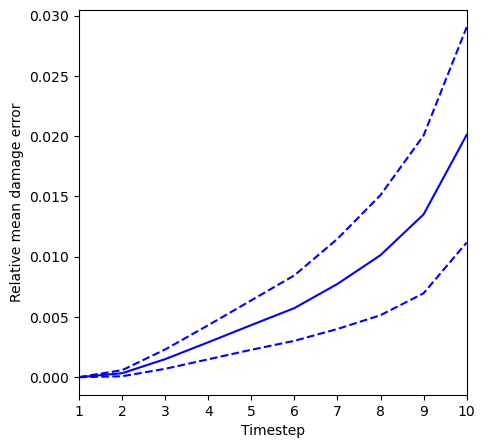

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), dpi=100)

axs.plot(np.arange(1, 11), dam_mean, 'b')
axs.plot(np.arange(1, 11), dam_mean+dam_std, 'b--')
axs.plot(np.arange(1, 11), dam_mean-dam_std, 'b--')
axs.set_xlabel('Timestep')
axs.set_ylabel('Relative mean damage error')
axs.set_xlim([1, 10])